In [107]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import psycopg2
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

%matplotlib inline

## Pre-Task: Describe the goals of your study

1. Understand which variables affect whether somebody on the Titanic survives or not
2. Build a model to predict whether somebody survives or not

## Part 1: Aquire the Data

In [ ]:
psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
password: gastudents

#### 1. Connect to the remote database

In [108]:
conn = psycopg2.connect("dbname='titanic' user='dsi_student'\ 
                        host='dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com' password='gastudents'")

In [109]:
pd.read_sql("SELECT * FROM information_schema.tables", con = conn);

#### 2. Query the database and aggregate the data

In [182]:
df = pd.read_sql("SELECT * FROM train", con = conn)
df.head(2)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


#### 5. What are the risks and assumptions of our data? 

## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored.  The following are the definitions usedfor sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws.  Some children travelled only with a nanny, therefore parch=0 for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

In [111]:
df.describe()

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,445.000000,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,667.500000,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,890.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [112]:
df[df["Pclass"] == 3].describe()

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,491.000000,491.000000,491.000000,491.0,355.000000,491.000000,491.000000,491.000000
mean,438.154786,439.154786,0.242363,3.0,25.140620,0.615071,0.393075,13.675550
std,264.441453,264.441453,0.428949,0.0,12.495398,1.374883,0.888861,11.778142
min,0.000000,1.000000,0.000000,3.0,0.420000,0.000000,0.000000,0.000000
25%,199.000000,200.000000,0.000000,3.0,NaN,0.000000,0.000000,7.750000
50%,431.000000,432.000000,0.000000,3.0,NaN,0.000000,0.000000,8.050000
75%,665.500000,666.500000,0.000000,3.0,NaN,1.000000,0.000000,15.500000
max,890.000000,891.000000,1.000000,3.0,74.000000,8.000000,6.000000,69.550000


* There are 891 passengers listed in this table
* ~55% (491/891) of the passengers traveled in 3rd class
* ~38% of the passengers in this dataset survived (but only ~13% of those who survived were in 3rd class) 

#### 2. Visualize the Data

In [8]:
df.to_csv("titanic.csv")

#### Passengers in Classes 1 and 2 had a higher survival rate than passengers in Class 3
<img src = "Class.png" width = "450" height = "200">

#### The survival rate was the highest among the youngest and the oldest, even though they were a small portion of the total number of passengers
<img src = "Age_hist.png" width = "450" height = "200">
<img src = "Age.png" width = "450" height = "200">

#### The survival rate was higher in females than males
<img src = "Sex.png" width = "450" height = "200">

#### People with small families or those who were single had a higher survival rate than people with larger families
<img src = "Family.png" width = "500" height = "300">

## Part 3: Data Wrangling

In [113]:
# Standardize continuous variables(age and fare), and create dummy variables for categoricals
import gzip
import dill

with gzip.open('union.dill.gz') as fin:
    union = dill.load(fin)
    
X = df[[u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare', u'Embarked']]
y = df[u'Survived']

X_transf = union.fit_transform(X)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator Imputer from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator FeatureUnion from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use 

In [114]:
# Add column names
col = ['scaled_age', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 
       'male', 'scaled_fare']
Xt = pd.DataFrame(data = X_transf, columns = col)

# Standardize and add back "SibSp" and "Parch"
from sklearn.preprocessing import scale
Xt["SibSp"] = scale(X["SibSp"])
Xt["Parch"] = scale(X["Parch"])

Xt.head()

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


,scaled_age,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,male,scaled_fare,SibSp,Parch
0,-0.592481,0.0,0.0,1.0,0.0,0.0,1.0,1.0,-0.502445,0.432793,-0.473674
1,0.638789,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.786845,0.432793,-0.473674
2,-0.284663,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.488854,-0.474545,-0.473674
3,0.407926,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.420730,0.432793,-0.473674
4,0.407926,0.0,0.0,1.0,0.0,0.0,1.0,1.0,-0.486337,-0.474545,-0.473674


In [183]:
Xt.shape

(891, 11)

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [115]:
# Train-test split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(Xt, y, stratify = y, test_size = 0.3)

In [116]:
# Select features (for logistic regression) from training set using RFECV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()
selector = RFECV(estimator, cv = 5)
selector.fit(X_train, y_train) 
col = selector.get_support()

In [117]:
# Transform X_train and X_test
X_train_RFECV = selector.transform(X_train)
X_train_best = pd.DataFrame(data = X_train_RFECV, columns = X_train.columns[col])
X_test_RFECV = selector.transform(X_test)
X_test_best = pd.DataFrame(data = X_test_RFECV, columns = X_test.columns[col])

In [118]:
# See which features were chosen
X_train_best.head(2)

,scaled_age,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,male,scaled_fare,SibSp,Parch
0,-0.669435,0.0,0.0,1.0,0.0,0.0,1.0,-0.324253,-0.474545,-0.473674
1,0.407926,1.0,0.0,0.0,1.0,0.0,1.0,9.667167,-0.474545,-0.473674


#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

Done previously

#### 3. Conduct the logistic regression

In [119]:
model = LogisticRegression()
model.fit(X_train_best, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 4. Examine the coefficients to see our correlations

In [190]:
Coeff = pd.DataFrame(data = model.coef_, columns = X_train_best.columns)
temp = pd.melt(Coeff)
temp["Abs value"] = temp["value"].abs()
print(temp.sort_values("Abs value", ascending = False))

      variable     value  Abs value
6         male -2.709137   2.709137
1     Pclass_1  1.154706   1.154706
4   Embarked_C  0.675393   0.675393
3     Pclass_3 -0.598048   0.598048
8        SibSp -0.493557   0.493557
0   scaled_age -0.446727   0.446727
2     Pclass_2  0.376475   0.376475
5   Embarked_Q  0.328518   0.328518
7  scaled_fare  0.296331   0.296331
9        Parch -0.113687   0.113687


#### 6. Test the Model by introducing a *Test* or *Validaton* set 

Already done

#### 7. Predict the class labels for the *Test* set

In [125]:
y_pred = model.predict(X_test_best)

#### 8. Predict the class probabilities for the *Test* set

In [126]:
y_prob = model.predict_proba(X_test_best)

#### 9. Evaluate the *Test* set

I'm not sure what this means

#### 10. Cross validate the test set

Not sure this is meaningful

#### 11. Check the Classification Report

In [127]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.84      0.82       165
          1       0.72      0.65      0.68       103

avg / total       0.77      0.77      0.77       268



#### 12. What do the classification metrics tell us?

The model is better at predicting "not survived" compared to "survived". Baseline accuracy for "survived" class is ~38%, and model predicts ~72%.

#### 13. Check the Confusion Matrix

In [128]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(data = confusion_matrix(y_test, y_pred), index = ["0 Actu", "1 Actu"], 
             columns = ["0 Pred", "1 Pred"])

,0 Pred,1 Pred
0 Actu,139,26
1 Actu,36,67


#### 14. What does the Confusion Matrix tell us? 

Overall accuracy is 76.8%

#### 15. Plot the ROC curve

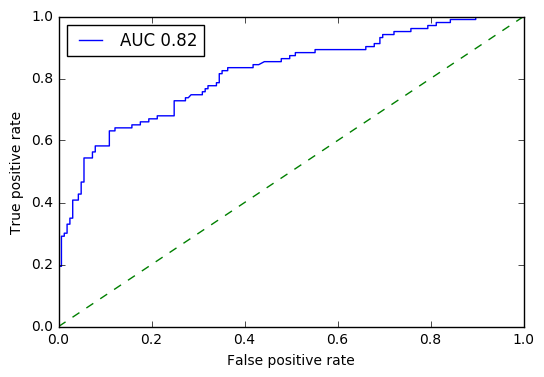

In [192]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(X_test_best))
area = roc_auc_score(y_test, model.decision_function(X_test_best))

plt.plot(fpr, tpr, label = "AUC %0.2f"%area)
plt.plot((0,1), (0,1), linestyle = "dashed")
plt.legend(loc = "best")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig("ROC1.png")
#plt.show()

#### 16. What does the ROC curve tell us?

True positive and false positive rate as threshold changes

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [130]:
from sklearn.model_selection import GridSearchCV

logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}
model2 = LogisticRegression()
selector2 = GridSearchCV(model2, logreg_parameters, cv = 5)
selector2.fit(X_train_best, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e...    2.44205e+00,   3.23746e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [131]:
selector2.best_params_

{'C': 0.33932217718953295, 'penalty': 'l2', 'solver': 'liblinear'}

In [132]:
selector2.best_score_

0.8186195826645265

In [133]:
selector2.score(X_test_best, y_test)

0.76865671641791045

Score is almost the same as the one from vanilla logistic regression (on the test set)

In [193]:
X_train_best.shape

(623, 10)

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

L1: Sum of coefficients

L2: Sum of square of coefficients

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

#### 5. [BONUS] Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

In [134]:
y_pred_90 = [1 if y_prob[i][1] >= 0.9 else 0 for i in range(len(y_prob))]
pd.DataFrame(data = confusion_matrix(y_test, y_pred_90), index = ["0 Actu", "1 Actu"], 
             columns = ["0 Pred", "1 Pred"])

,0 Pred,1 Pred
0 Actu,164,1
1 Actu,82,21


## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [135]:
from sklearn.neighbors import KNeighborsClassifier as kNN

model3 = kNN()
kNN_grid = {"n_neighbors": np.arange(1,11), "weights": ["uniform", "distance"]}
selector3 = GridSearchCV(model3, kNN_grid, cv = 5)
selector3.fit(X_train_best, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [136]:
selector3.best_params_

{'n_neighbors': 5, 'weights': 'uniform'}

In [137]:
selector3.best_score_

0.8025682182985554

In [138]:
selector3.score(X_test_best, y_test)

0.79477611940298509

Marginally better than LR

#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

As number of neighbors increases, bias increases and variance decreases

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

Where number of features is high. kNN will overfit, but LR can be regularized

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

In [139]:
y_pred_kNN = selector3.predict(X_test_best)

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

In [140]:
print("kNN:")
pd.DataFrame(data = confusion_matrix(y_test, y_pred_kNN), index = ["0 Actu", "1 Actu"], 
             columns = ["0 Pred", "1 Pred"])

kNN:


,0 Pred,1 Pred
0 Actu,143,22
1 Actu,33,70


In [141]:
print("LR:")
pd.DataFrame(data = confusion_matrix(y_test, y_pred), index = ["0 Actu", "1 Actu"], 
             columns = ["0 Pred", "1 Pred"])

LR:


,0 Pred,1 Pred
0 Actu,139,26
1 Actu,36,67


#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

In [142]:
kNN_prob = selector3.predict_proba(X_test_best)
kNN_prob = kNN_prob[:, 1]

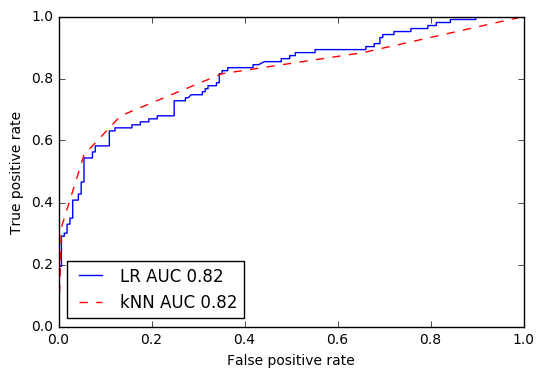

In [194]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, model.decision_function(X_test_best))
area_lr = roc_auc_score(y_test, model.decision_function(X_test_best))
fpr_kNN, tpr_kNN, thresholds_kNN = roc_curve(y_test, kNN_prob)
area_kNN = roc_auc_score(y_test, kNN_prob)
plt.plot(fpr_lr, tpr_lr, color = "b", label = "LR AUC %0.2f"%area_lr)
plt.plot(fpr_kNN, tpr_kNN, color = "r", label = "kNN AUC %0.2f"%area_kNN, linestyle = "dashed")
plt.legend(loc = "best")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig("ROC2.png")
#plt.show()

## Part 7: [BONUS] Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

In [145]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}
model4 = LogisticRegression()
selector4 = GridSearchCV(model4, logreg_parameters, cv = 5, scoring = "average_precision")
selector4.fit(X_train_best, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e...    2.44205e+00,   3.23746e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

In [146]:
selector4.best_params_

{'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [147]:
selector4.best_score_

0.83489416014644446

In [148]:
selector4.score(X_test_best, y_test)

0.78702744169138794

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

In [149]:
y_pred_avp = selector4.predict(X_test_best)

In [150]:
print("LR accuracy:")
pd.DataFrame(data = confusion_matrix(y_test, y_pred), 
             index = ["0 Actu", "1 Actu"], 
             columns = ["0 Pred", "1 Pred"])

LR accuracy:


,0 Pred,1 Pred
0 Actu,139,26
1 Actu,36,67


In [151]:
print("LR average precision:")
pd.DataFrame(data = confusion_matrix(y_test, y_pred_avp), index = ["0 Actu", "1 Actu"], 
             columns = ["0 Pred", "1 Pred"])

LR average precision:


,0 Pred,1 Pred
0 Actu,138,27
1 Actu,36,67


#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

In [152]:
y4_decfun = selector4.decision_function(X_test_best)

In [153]:
y_test.shape

(268,)

In [154]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y4_decfun)

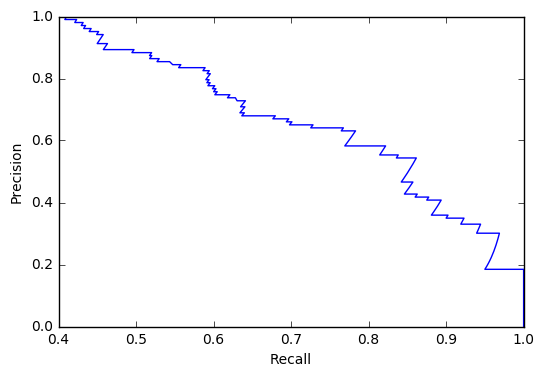

In [196]:
plt.plot(precision, recall, color = "b", )
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig("PR.png")
#plt.show()

## Part 7b [KV]: Try SVM

In [178]:
from sklearn.svm import SVC

svc_params = {
    'kernel':['rbf','linear'],
    'C':np.logspace(-3,3,5),
    }
model5 = SVC()
selector5 = GridSearchCV(model5, svc_params, cv = 5)
selector5.fit(X_train_best, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'linear'], 'C': array([  1.00000e-03,   3.16228e-02,   1.00000e+00,   3.16228e+01,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [179]:
selector5.best_params_

{'C': 1.0, 'kernel': 'rbf'}

In [180]:
selector5.best_score_

0.8330658105939005

In [181]:
selector5.score(X_test_best, y_test)

0.78358208955223885

## Part 8: [VERY BONUS] Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

#### 3. Plot all three optimized models' ROC curves on the same plot. 

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier?

#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.